### Import packages and modules



In [2]:
# Import Python packages
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import os
import plotly.express as px
from getpass import getpass

# Import Snowflake modules
from snowflake.snowpark import Session 
import snowflake.snowpark.functions as F 
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

### Connect to Snowflake and set the context for the notebook 



In [3]:
snow_acct=getpass()
userID=getpass()
pw=getpass()

connection_parameters = {
    "account":snow_acct,
    "user":userID,
    "password":pw,
    "role":"datasci",
    "warehouse":"datasci_wh",
    "database":"analytics",
    "schema":"readmit"
}

session = Session.builder.configs(connection_parameters).create()
print(session.sql("select current_role(), current_warehouse(), current_database(), current_schema(), current_region(), current_client()").collect())

········
········
········
[Row(CURRENT_ROLE()='DATASCI', CURRENT_WAREHOUSE()='DATASCI_WH', CURRENT_DATABASE()='ANALYTICS', CURRENT_SCHEMA()='READMIT', CURRENT_REGION()='PUBLIC.AWS_US_WEST_2', CURRENT_CLIENT()='PythonSnowpark 1.3.0')]


### Create a Snowpark dataframe, which references a table in Snowflake, to start manipulating our data
### Explore 10 rows of data



In [9]:
readmissions_df=session.table('readmissions_enriched')
readmissions_df.sample(n=10).show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CITY_LAT"  |"CITY_LONG"  |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"                                   |"HOSPITAL_STATE"  |"DIAGNOSIS"  |"PATIENT_NUMBER"  |"DV_READMIT_FLAG"  |"

### How large is this Snowpark dataframe? 



In [10]:
import sys
snowpark_size = sys.getsizeof(readmissions_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB


####  The Snowpark dataframe has zero size in the Python client here since the data is still in Snowflake



### Filter the data for just New Jersey and sort by readmission and diagnosis. What does the underlying SQL execution plan look like? 



In [11]:
nj_df = readmissions_df.filter(F.col("HOSPITAL_STATE") == 'NJ').order_by(["DV_READMIT_FLAG", "DIAGNOSIS"], ascending=[0, 0])
nj_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT  *  FROM readmissions_enriched WHERE ("HOSPITAL_STATE" = 'NJ') ORDER BY "DV_READMIT_FLAG" DESC NULLS LAST, "DIAGNOSIS" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=1
    partitionsAssigned=1
    bytesAssigned=5365760
Operations:
1:0     ->Result  READMISSIONS_ENRICHED.CITY_LAT, READMISSIONS_ENRICHED.CITY_LONG, READMISSIONS_ENRICHED.HOSPITAL_LAT, READMISSIONS_ENRICHED.HOSPITAL_LONG, READMISSIONS_ENRICHED.HOSPITAL_NAME, READMISSIONS_ENRICHED.HOSPITAL_STATE, READMISSIONS_ENRICHED.DIAGNOSIS, READMISSIONS_ENRICHED.PATIENT_NUMBER, READMISSIONS_ENRICHED.DV_READMIT_FLAG, READMISSIONS_ENRICHED.ADMIT_DATE, READMISSIONS_ENRICHED.LENGTH_OF_STAY, READMISSIONS_ENRICHED.PRIOR_IP_ADMITS, READMISSIONS_ENRICHED.CHRONIC_CONDITIONS_NUMBER, READMISSIONS_ENRICHED.PATIENT_AGE, READMISSIONS_ENRICHED.ORDER_SET_USED, READMISSIONS_ENRICHED.HOSPITAL_ID, READMISSIONS_ENRICHED.HOSPITAL_ADDRESS, READMISSIONS_ENRICHED.HOSPIT

### How many patients and readmissions are there? 



In [12]:
print('The total number of patients in the dataset is',readmissions_df.count())
print('The number of patients with a readmission is',readmissions_df.filter(col('"DV_READMIT_FLAG"')==1).count())
print('The number of patients without a readmission is',readmissions_df.filter(col('"DV_READMIT_FLAG"')==0).count())

The total number of patients in the dataset is 75675
The number of patients with a readmission is 17007
The number of patients without a readmission is 58668


### Select features likely to be predictive of readmission and generate summary stats



In [13]:
readmissions_df_features = readmissions_df.select("PATIENT_AGE", "BMI", "LENGTH_OF_STAY", "ORDER_SET_USED", "CHRONIC_CONDITIONS_NUMBER",  "SBUX_COUNT", "DV_READMIT_FLAG" )
readmissions_df_features.describe().show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"PATIENT_AGE"       |"BMI"               |"LENGTH_OF_STAY"   |"ORDER_SET_USED"     |"CHRONIC_CONDITIONS_NUMBER"  |"SBUX_COUNT"        |"DV_READMIT_FLAG"   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |75675.0             |75675.0             |75675.0            |75675.0              |75675.0                      |35931.0             |75675.0             |
|mean       |58.088008           |24.50865147010241   |4.816597           |0.399498             |2.015738                     |2.530016            |0.224737            |
|stddev     |13.011103565801019  |3.5000372760173843  |2.779307287796727  |0.48979791751292695  |0.4733318075092778           |1.4613719581270197  |0.

### Count the number of null/missing values for each input value. Perhaps we may need to do some imputation.



In [14]:
column_names=readmissions_df_features.columns
for i in column_names:
    print('Column',i,'has',readmissions_df_features.filter(col(i).isNull()).count(),'missing values')

Column PATIENT_AGE has 0 missing values
Column BMI has 0 missing values
Column LENGTH_OF_STAY has 0 missing values
Column ORDER_SET_USED has 0 missing values
Column CHRONIC_CONDITIONS_NUMBER has 0 missing values
Column SBUX_COUNT has 39744 missing values
Column DV_READMIT_FLAG has 0 missing values


### Since our zip codes without any Starbucks locations show up as `null`, let's replace those missing values with `0` for our model



In [15]:
readmissions_df_features = readmissions_df_features.fillna(0, subset="SBUX_COUNT")
for i in column_names:
    print('Column',i,'has',readmissions_df_features.filter(col(i).isNull()).count(),'missing values!')

Column PATIENT_AGE has 0 missing values!
Column BMI has 0 missing values!
Column LENGTH_OF_STAY has 0 missing values!
Column ORDER_SET_USED has 0 missing values!
Column CHRONIC_CONDITIONS_NUMBER has 0 missing values!
Column SBUX_COUNT has 0 missing values!
Column DV_READMIT_FLAG has 0 missing values!


### Visually examine the distribution of patient age to see if any transformations should be applied



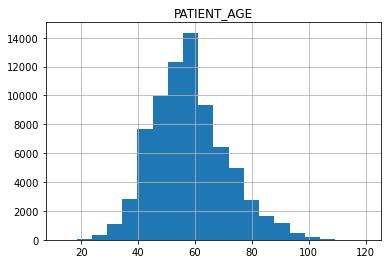

In [16]:
ax = readmissions_df_features.to_pandas().hist(column="PATIENT_AGE", bins=20)

### Explore correlations between our outcome and predictors to see if there is any predictive power or multicollinearlity.



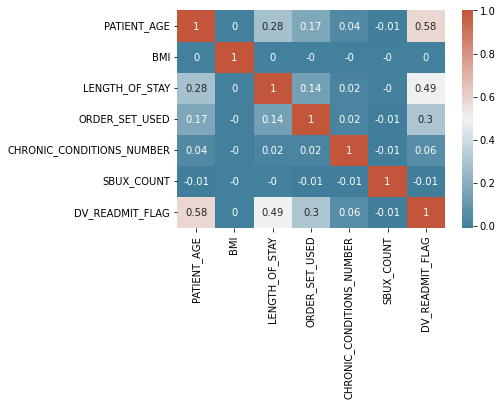

In [17]:
#Create a pandas dataframe to put the correlations into.
corr_df=pd.DataFrame(columns=column_names,index=column_names,dtype=float)


#Calculate the correlations
for i,j in combinations(column_names,2):
    corr_df.at[i,j]=round(readmissions_df_features.corr(col(i),col(j)),2)
    corr_df.at[j,i]=corr_df.at[i,j] 

#The diagonal will always be set to 1 since it is matching variables
np.fill_diagonal(corr_df.values, 1.0)

sns.heatmap(corr_df, cmap=sns.diverging_palette(230, 20, as_cmap=True), annot=True);

### Save our model-ready table with imputed values as a Snowflake table



In [18]:
readmissions_df_features.write.mode("overwrite").save_as_table("analytics.readmit.readmissions_imp")

### This staging area will surface as place to put python objects for future use (for example model scoring)



In [19]:
session.sql("CREATE OR REPLACE STAGE readmissions_model_stage").collect()

[Row(status='Stage area READMISSIONS_MODEL_STAGE successfully created.')]

### Define a function for building a logistic regression model



In [20]:
def train_model(session: Session, 
    training_table: str, 
    feature_columns: list, 
    target_variable: str,
    model_name: str,
) -> T.Variant:
    
    #Import packages for modeling
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from joblib import dump

    #Specify the table for training the model. The pandas dataframe will live on the Snowflake compute.
    readmissions_py_df=session.table(training_table).to_pandas()
    
    #Create our input and output features
    X=readmissions_py_df[feature_columns]
    y=readmissions_py_df[target_variable]

    #Split the data into a train and test dataset. 75% train / 25% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 99)

    #Fit the model
    model = LogisticRegression().fit(X_train,y_train)
    
  # Save model
    dump(model, "/tmp/" + model_name)
    session.file.put(
        "/tmp/" + model_name,
        "@readmissions_model_stage",
        auto_compress=False,
        overwrite=True
    )


#Check and return model accuracy based on our two data sets
    return {"Misclassification Rate on Train": round(model.score(X_train, y_train),3), 
            "Misclassification Rate on Test": round(model.score(X_test, y_test),3)}



### In Snowflake, when running a model function we first need to register it as a stored procedure. We will store the function in the stage created earlier.



In [21]:
train_model_snowflake = session.sproc.register(func=train_model, 
                                                name="sproc_train_model", 
                                                is_permanent=True, 
                                                replace=True, 
                                                stage_location="@readmissions_model_stage", 
                                                packages=["snowflake-snowpark-python", "scikit-learn", "joblib"])

The version of package snowflake-snowpark-python in the local environment is 1.3.0, which does not fit the criteria for the requirement snowflake-snowpark-python. Your UDF might not work when the package version is different between the server and your local environment


### Scale up our data science compute cluster to an XL to speed up model training



In [22]:
session.sql("alter warehouse datasci_wh set warehouse_size = xlarge").collect()

[Row(status='Statement executed successfully.')]

### Specify our inputs, output, training table, submit those values into our stored procedure, and run the training SPROC

In [23]:
# Specify input variables, the labeled variable, and the input dataset
training_table = "analytics.readmit.readmissions_imp" 
feature_cols = ["PATIENT_AGE",'BMI','LENGTH_OF_STAY','ORDER_SET_USED','CHRONIC_CONDITIONS_NUMBER', 'SBUX_COUNT'] 
target_col = "DV_READMIT_FLAG"
model_name = "readmit_logistic.sav"


# Call the training stored procedure and see the misclassification rate outputs
feature_contributions = train_model_snowflake(session,
    training_table,
    feature_cols,
    target_col,
    model_name)
print(feature_contributions)

{
  "Misclassification Rate on Test": 0.905,
  "Misclassification Rate on Train": 0.902
}


### Now that model training is complete we can scale down our compute cluster



In [24]:
session.sql("alter warehouse datasci_wh set warehouse_size=small").collect()

[Row(status='Statement executed successfully.')]

### Now that we have our model file we can define a function to predict readmission for new observations



In [25]:
def logistic_predict(X: pd.DataFrame) -> pd.Series:
    
    # Import packages
    import sys
    from joblib import load

    # Get the import directory where the model file is stored
    import_dir = sys._xoptions["snowflake_import_directory"]

    # Load the model
    model = load(import_dir + "readmit_logistic.sav")

    # Get predictions
    predictions = model.predict(X)

    # Return rounded predictions
    return predictions.round(2)

### Register our prediction UDF for reuse



In [26]:
logistic_predict_readmission = session.udf.register(
    func=logistic_predict,
    name="udf_logistic_readmit_predict",
    stage_location="@readmissions_model_stage",
    input_types=[T.FloatType()] * len(feature_cols),
    return_type=T.FloatType(),
    replace=True,
    is_permanent=True,
    imports=["@readmissions_model_stage/readmit_logistic.sav"],
    packages=["scikit-learn", "joblib"]
)

### How does our model fair on our train dataset?



In [27]:
train_pred = readmissions_df_features.select(
    "DV_READMIT_FLAG",
    logistic_predict_readmission(*feature_cols).alias("prediction")
)
train_pred.show()

------------------------------------
|"DV_READMIT_FLAG"  |"PREDICTION"  |
------------------------------------
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
|1                  |1.0           |
|0                  |0.0           |
|0                  |0.0           |
|0                  |0.0           |
------------------------------------



### Predict readmissions of our new patients



In [28]:
new_patients_df=session.table('new_patients_enriched')
new_patients_imp = new_patients_df.fillna(0, subset="SBUX_COUNT")
new_patients_imp.write.mode("overwrite").save_as_table("analytics.readmit.new_patients_imp")
new_patients_predictions_df = new_patients_imp.select("NPI", "HOSPITAL_LAT", "HOSPITAL_LONG", "HOSPITAL_NAME", "HOSPITAL_STATE", logistic_predict_readmission(*feature_cols).alias("predicted_readmission"))
new_patients_predictions_df.write.mode("overwrite").save_as_table("new_patient_predictions_snowpark")
new_patients_predictions_df.show()

---------------------------------------------------------------------------------------------------------------------
|"NPI"       |"HOSPITAL_LAT"  |"HOSPITAL_LONG"  |"HOSPITAL_NAME"       |"HOSPITAL_STATE"  |"PREDICTED_READMISSION"  |
---------------------------------------------------------------------------------------------------------------------
|1053675397  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1891067815  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1093063927  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1427401413  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1518982958  |NULL            |NULL             |OCEAN MEDICAL CENTER  |NJ                |0.0                      |
|1285071134  |NULL            |NULL             |OCEAN M

### Prototype a map of providers in New Jersey with the most predicted readmissions 



In [30]:
# Pull New Jersey predictions aggregated by provider into a pandas dataframe
nj_predictions_df = new_patients_predictions_df.filter(F.col("HOSPITAL_STATE") == 'NJ').groupBy("HOSPITAL_NAME", "HOSPITAL_LAT", "HOSPITAL_LONG").agg(F.sum("PREDICTED_READMISSION").alias("TOTAL_PRED_READMITS")).to_pandas()

# Visualize on a map
# This is a prototype of what we'll eventually make in Tableau
# Where are our providers with the most predicted readmissions?
fig = px.scatter_mapbox(
    nj_predictions_df, 
    lat="HOSPITAL_LAT", 
    lon="HOSPITAL_LONG", 
    hover_name="HOSPITAL_NAME", 
    size="TOTAL_PRED_READMITS",
    color="TOTAL_PRED_READMITS",
    zoom=8, 
    height=800,
    width=1000
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

### Close our Snowpark session



In [ ]:
session.close()